In [ ]:
!pip install transformers diffusers torch accelerate omegaconf huggingface_hub

Model Download

In [ ]:
from huggingface_hub import hf_hub_download
hf_hub_download(
    repo_id="faizalnf1800/sd1.5-model-for-inference",
    filename="meinamix_meinaV11.safetensors",
    repo_type="model",
    local_dir="/content")

In [ ]:
from diffusers import(
    StableDiffusionPipeline,
    AutoPipelineForImage2Image,
    DPMSolverMultistepScheduler,
    AutoencoderKL,
)
import transformers
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO

if torch.cuda.is_available():
    device_name = torch.device("cuda")
    torch_dtype = torch.float16
    # torch_dtype = torch.float32
else:
    device_name = torch.device("cpu")
    torch_dtype = torch.bfloat16

In [ ]:
# repo = "/content/stingermix_v30.safetensors"
# repo = "/content/stingermix_v40.safetensors"
# repo = "/content/everyjourney.safetensors"
repo = "/content/meinamix_meinaV11.safetensors"
# repo = "larosbell_3d.safetensors"
# vae_id = "ClearVAE_V2.3_fp16.safetensors"


In [ ]:
# pipe = StableDiffusionPipeline.from_pretrained("faizalnf1800/StingerMix-v4.0-Pruned-SD1.5",
#                                             torch_dtype=torch_dtype,
#                                             use_karras_sigmas=True,
#                                             algorithm_type="sde-dpmsolver++",
#                                             use_safetensors=True)
# pipe = AutoPipelineForImage2Image.from_pretrained("faizalnf1800/StingerMix-v4.0-Pruned-SD1.5",
#                                             torch_dtype=torch_dtype,
#                                             use_karras_sigmas=True,
#                                             algorithm_type="sde-dpmsolver++",
#                                             use_safetensors=True)
pipe = StableDiffusionPipeline.from_single_file(repo,
                                            torch_dtype=torch_dtype,
                                            use_karras_sigmas=True,
                                            algorithm_type="sde-dpmsolver++",
                                            use_safetensors=True)
# vae = AutoencoderKL.from_single_file(vae_id, torch_dtype=torch_dtype)
# pipe = StableDiffusionPipeline.from_single_file(repo,
#                                             torch_dtype=torch_dtype,
#                                             use_karras_sigmas=True,
#                                             algorithm_type="sde-dpmsolver++",
#                                             use_safetensors=True,
#                                             vae=vae)
pipe.to(device_name)
pipe.safety_checker = None
pipe.requires_safety_checker = False

pipe.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe.scheduler.config
)

Lora

In [ ]:
# pipe.load_lora_weights("faizalnf1800/sidebags-earring-anime-woman-lora")
pipe.load_lora_weights(".",weight_name="pytorch_lora_weights.safetensors")

In [ ]:
lora_scale=1.2
pipe.fuse_lora(lora_scale=lora_scale)

In [ ]:
pipe.unfuse_lora()

In [ ]:
# @title Inference Settings

# prompt = "SIBeaR,portrait,beautiful,anime woman,sitting on black horses,long black hair,halfbody,wavy hair,sidebangs hairstyle and earring,1girl,novel illustration,photorealistic,masterpiece,detailed"
prompt = "beautiful woman commander,defense wall,public speech,brave,optimism,no fear expression,strategic atmosphere,wallpaper,long distance camera view,speech platform,front line defense wall,anime style,illustration,indonesia flag,crowd people background,futuristic background,detailed,high quality,masterpiece" # @param {type:"string"}
negative_prompt = "EasyNegative,worst quality,bad hand,interlocked finger,bad anatomy,extra limbs,extra arms,extra leg,watermark,nonsensical picture,lifeless picture,undetailed face,usa flag,america flag" # @param {type:"string"}
# width = 512
width = 768 # @param {type:"integer"}
height = 512 # @param {type:"integer"}
# height = 768
size=str(width)+"x"+str(height)
cfg_scale = 7 # @param {type:"integer"}
steps = 20 # @param {type:"integer"}
sampler = "DPM++ SDE Karras" # @param {type:"string"}
modelname = "MeinaMix11" # @param {type:"string"}
loraname = "" # @param {type:"string"}

**Text to Image**

In [ ]:
import random

manual_seed = random.randint(1,999999)
print(manual_seed)
generator = torch.Generator(device="cuda").manual_seed(manual_seed)
images = pipe(
            prompt = prompt,
            negative_prompt = negative_prompt,
            width = width,
            height = height,
            guidance_scale = cfg_scale,
            num_inference_steps = steps,
            num_images_per_prompt = 4,
            generator = generator
        ).images

111256


  0%|          | 0/20 [00:00<?, ?it/s]

View Image

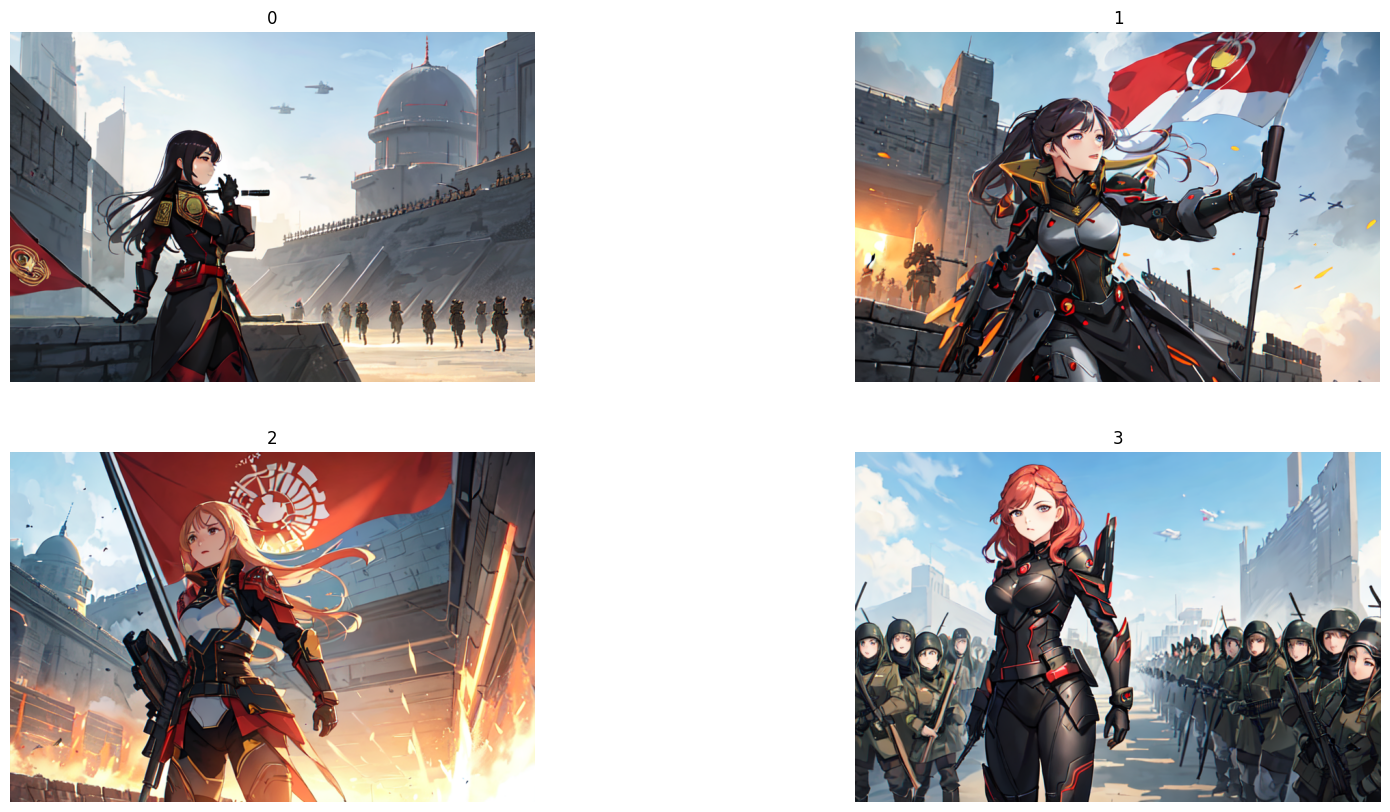

In [ ]:
def plot_images(images):
    N = len(images)
    n_cols = 2
    n_rows = int(np.ceil(N / n_cols))

    plt.figure(figsize = (20, 5 * n_rows))
    for i in range(len(images)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.title(i)
        plt.imshow(np.array(images[i]))
        plt.axis(False)
    plt.show()
plot_images(images)

image to image

In [ ]:
from diffusers.utils import load_image

image_path = 'knight.jpeg'
#init_image = = Image.open(image_path).convert("RGB")
init_image = load_image(image_path)
img_strength = 1.0

In [ ]:
import random

manual_seed = random.randint(1,999999)
print(manual_seed)
generator = torch.Generator(device="cuda").manual_seed(manual_seed)
images = pipe(
            prompt = prompt,
            negative_prompt = negative_prompt,
            width = width,
            height = height,
            image = init_image,
            strength = img_strength,
            guidance_scale = cfg_scale,
            num_inference_steps = steps,
            num_images_per_prompt = 4,
            generator = generator
        ).images

In [ ]:
images

Insert Metadata

In [ ]:
!pip install pyexiv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.9 MB/s eta 0:00:00


In [ ]:
import pyexiv2

for i in range(len(images)):
  images[i].save(f"image{i}.png")
  # metadata_diffusers = {
  #           "prompt": prompt+"<lora:"+loraname+":"+str(lora_scale)+">",
  #           "negativePrompt": negative_prompt,
  #           "steps": steps,
  #           "samplerName": sampler,
  #           "cfgScale": cfg_scale,
  #           "seed": manual_seed,
  #           "clipskip": 1,
  #           "baseModel": "SD 1.5",
  #           "checkpointModel": modelname,
  #           "loraModel": loraname,
  # }
  metadata_diffusers = {
            "prompt": prompt,
            "negativePrompt": negative_prompt,
            "steps": steps,
            "samplerName": sampler,
            "cfgScale": cfg_scale,
            "seed": manual_seed,
            "clipskip": 1,
            "baseModel": "SD 1.5",
            "checkpointModel": modelname,
            "loraModel": loraname,
  }

  new_metadata = {
        "Exif.Photo.UserComment": metadata_diffusers
  }
  img = pyexiv2.Image(f"image{i}.png")
  img.modify_exif(new_metadata)

Check Metadata

In [ ]:
#Check Metadata
from PIL import Image

def view_image_metadata(image_path):
    # Open the image file
    with Image.open(image_path) as img:
        # Get the metadata
        metadata = img.info
    print(metadata)
    # Display the metadata
    print("Image Metadata:")
    for key, value in metadata.items():
        print(f"{key}: {value}")

# Example usage
image_path = "/content/image0.png"
view_image_metadata(image_path)

In [ ]:
img = pyexiv2.Image(r'image0.png')
data = img.read_exif()
data

In [ ]:
!pip install huggingface_hub

In [ ]:
!huggingface-cli login

In [ ]:
pipe.push_to_hub("faizalnf1800/LarosBell-3D-With-Vae-SD1.5")

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

'https://huggingface.co/faizalnf1800/LarosBell-3D-With-Vae-SD1.5/tree/main/'

In [ ]:
import torch

# Save the safetensors file
torch.save(pipe, "sidebags-earring-anime-woman-lora-stingermix.safetensors")
torch.save(pipe, "sidebags-earring-anime-woman-lora-stingermix.pt")

In [ ]:
!pip install huggingface_hub

In [ ]:
!huggingface-cli login

In [ ]:
!huggingface-cli upload faizalnf1800/sidebags-earring-anime-woman-lora /content/sidebags-earring-anime-woman-lora-stingermix.safetensors model.safetensors

sidebags-earring-anime-woman-lora-stingermix.safetensors: 100% 2.14G/2.14G [00:52<00:00, 41.1MB/s]
https://huggingface.co/faizalnf1800/sidebags-earring-anime-woman-lora/blob/main/model.safetensors


In [ ]:
!huggingface-cli upload faizalnf1800/sidebags-earring-anime-woman-lora /content/sidebags-earring-anime-woman-lora-stingermix.pt model.pt

https://huggingface.co/faizalnf1800/sidebags-earring-anime-woman-lora/blob/main/model.pt
